# Training and Testing an MLP for Performance Prediction

In this notebook you will learn about training and testing a Multi Layer Perceptron (MLP). 
This will introduction 
you to (or refresh your knowledge about):
1. how to prepare your dataset, i.e., normalization, and performing the training, validation and testing splits; 
2. how define an MLP, including input size, hidden layers, output layer and activation functions;
3. how to train and validate your model by interpreting training and validation loss;
4. how to evaluate the trained model on the test set.

This notebook is developed using the open source machine learning framework PyTorch, however all machine 
learning concepts covered in this tutorial are applicable in all other machine learning frameworks. 

To experiment with this notebook use the button below to open it in Colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aldolipani/ICIN20_ML4N_Tutorial/blob/master/2%20-%20Training%20and%20Testing%20an%20MLP.ipynb){target="_blank"}

Now that you are in Colab, before getting started, let's execute the following code cell full of linux commands 
to make sure that all required packages and files are available in your workspace.

In [29]:
# these commands install PyTorch, and a visualization tool that makes training ML models in a jupyter notebook beautiful!
!pip -q install torch torchvision
!pip -q install livelossplot

# this downloads the dataset
!wget https://raw.githubusercontent.com/aldolipani/ICIN20_ML4N_Tutorial/master/ps.csv

/bin/sh: wget: command not found


In [17]:
import pandas as pd
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset

from typing import List
from livelossplot import PlotLosses

In [18]:
df = pd.read_csv("ps.csv")
data = df.to_numpy()

In [19]:
def train_validation_test_splits(data, train_size, validation_size):
    assert(train_size + validation_size < 1.0)
    np.random.shuffle(data)
    n = int(train_size * len(data))
    train, rest = data[:n,:], data[n:,:]
    n = int(validation_size * len(data))
    validation, test = rest[:n,:], rest[n:,:]
    return train, validation, test

train, validation, test = train_validation_test_splits(data, 0.8, 0.1)

print(data.shape)

print(train.shape)
print(validation.shape)
print(test.shape)

(29967, 33)
(23973, 33)
(2996, 33)
(2998, 33)


In [20]:
def to_one_hot(y):
    y = y.reshape(-1).astype(int)
    n_ones = np.max(y) + 1
    return np.eye(n_ones)[y]

train_x, train_y = np.hsplit(train, [train.shape[1] - 1])
#train_y = to_one_hot(train_y)
train_y = train_y.reshape(-1).astype(int)

validation_x, validation_y = np.hsplit(validation, [validation.shape[1] - 1])
validation_y = validation_y.reshape(-1).astype(int)

test_x, test_y = np.hsplit(test, [test.shape[1] - 1])
test_y = test_y.reshape(-1).astype(int)

In [21]:
min = train_x.min(axis=0)
max = train_x.max(axis=0)

train_x = (train_x - min)/(max - min)
validation_x = (validation_x - min)/(max - min)
test_x = (test_x - min)/(max - min)

In [22]:
train_x

array([[0.61400385, 0.17444892, 0.99939942, ..., 0.3447754 , 0.10227378,
        0.34732066],
       [0.05954612, 0.1888257 , 0.99974006, ..., 0.55545655, 0.11787854,
        0.55953102],
       [0.72353125, 0.17600177, 0.99957537, ..., 0.39093262, 0.10417025,
        0.39381291],
       ...,
       [0.52966023, 0.17474776, 0.99941219, ..., 0.35894716, 0.10256324,
        0.36159528],
       [0.27492888, 0.17520408, 0.9992759 , ..., 0.37113176, 0.10368116,
        0.37386832],
       [0.74624713, 0.17578453, 0.99958388, ..., 0.38221317, 0.10375977,
        0.38503017]])

In [23]:
class MLP(nn.Module):
    
    def __init__(self, input_size:int=10, hidden:List[int]=[10, 20, 30], output_size:int = 3):
        super(MLP, self).__init__()
        self.fcs = nn.ModuleList()
        output_sizes = hidden + [output_size]
        print(output_sizes)
        for output_size in output_sizes:
            self.fcs.append(nn.Linear(input_size, output_size))
            input_size = output_size
        
    def forward(self, x):
        for fc in self.fcs:
            y = F.sigmoid(fc(x))
            x = y
        y = F.softmax(y)
        return y
        
        

In [24]:
model = MLP(32, [10], 3)
model.parameters()

[10, 3]


<generator object Module.parameters at 0x13dda9308>

In [25]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [26]:
batch_size = 32

train_dataset = TensorDataset(
    torch.from_numpy(train_x).float(), 
    torch.from_numpy(train_y))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = TensorDataset(
    torch.from_numpy(validation_x).float(), 
    torch.from_numpy(validation_y))
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


test_dataset = TensorDataset(
    torch.from_numpy(test_x).float(), 
    torch.from_numpy(test_y))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


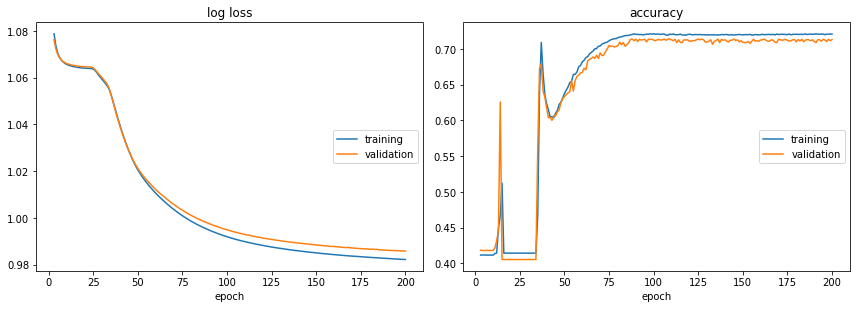

log loss:
training   (min:    0.982, max:    1.095, cur:    0.982)
validation (min:    0.986, max:    1.090, cur:    0.986)

accuracy:
training   (min:    0.370, max:    0.721, cur:    0.721)
validation (min:    0.405, max:    0.714, cur:    0.713)


In [27]:
epochs = 200

data_loader = {'train':train_loader, 'validation':validation_loader}

liveloss = PlotLosses()
for epoch in range(epochs):  # loop over the dataset multiple times
    
    logs = {}
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        for i, batch in enumerate(data_loader[phase]):
            x, y = batch
            
            # forward + backward + optimize
            y_pred = model(x)
            # compute loss
            loss = criterion(y_pred, y)
            
            if phase == 'train':
                # reset optimizer
                optimizer.zero_grad()
                # backward step
                loss.backward()
                # update weights
                optimizer.step()
            
            # print statistics
            _, y_pred = torch.max(y_pred.detach(), 1)
            running_loss += loss.detach() * x.size(0)    
            running_corrects += torch.sum(y_pred == y)
        
        prefix = ''
        if phase == 'validation':
            prefix = 'val_'
        
        epoch_loss = running_loss / len(data_loader[phase].dataset)
        logs[prefix + 'log loss'] = epoch_loss.item()
        epoch_acc = running_corrects.float() / len(data_loader[phase].dataset)
        logs[prefix + 'accuracy'] = epoch_acc.item()
    
    liveloss.update(logs)
    liveloss.draw()

In [28]:
model.eval()

running_loss = 0.0
running_corrects = 0
for i, batch in enumerate(test_loader):
    x, y = batch
    y_pred = model(x)
    _, y_pred = torch.max(y_pred.detach(), 1)
    running_corrects += torch.sum(y_pred == y)

acc = running_corrects.float() / len(data_loader[phase].dataset)
print(acc)

tensor(0.7213)


/Users/ucaclip/opt/anaconda3/envs/ml4n/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/ucaclip/opt/anaconda3/envs/ml4n/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
